# Data Exploration and Visualization of NOM Data in NMDC (FT ICR-MS)
This notebook identifies natural organic matter (NOM) data sets in the National Microbiome Data Collaborative (NMDC), filters those datasets based on quality control metrics, and analyzes the molecular composition of the chosen datasets via heatmaps and Van Krevelen plots.
This notebook uses the `nmdc_api_utilities` package (as of March 2025) to do this exploration. It involves using `nmdc_api_utilites` objects to make NMDC API requests easier, and using utility function to help us with data processing tasks. More information about the package can be found [here](https://microbiomedata.github.io/nmdc_api_utilities/)

In [1]:
%%capture
## First need to install locally the nmdc_api_utilities
%pip install nmdc_api_utilities;
## And also install python-dotenv for development use
%pip install python-dotenv

## Set up environment variables
**You can disregard this section of code unless you have interest in testing this on the development API.**

Using pythons python-dotenv package, load the environment variables from the system. This chunk of code is used in the Github CI/CD pipelines to test our development API. The variable can be used when creating `nmdc_api_utilities` objects. If you do not have the environment variable `ENV` set in a .env file, this code with default to the variable "prod" - which tells nmdc_api_utilities to use the production API URL.

In [2]:
# set up environment variables
from dotenv import load_dotenv
import os
load_dotenv()
# load the environment variable ENV. If it does not exist, default to "prod"
ENV = os.environ.get("ENV", "prod")

In [3]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from matplotlib.patches import Patch
import nmdc_api_utilities

## Define a function to split a list into chunks 

Since we will need to use a list of ids to query a new collection in the API, we need to limit the number of ids we put in a query. This function splits a list into chunks of 100. Note that the `chunk_size` has a default of 100, but can be adjusted.

In [4]:
# Define a function to split ids into chunks
def split_list(input_list, chunk_size=100):
    result = []
    
    for i in range(0, len(input_list), chunk_size):
        result.append(input_list[i:i + chunk_size])
        
    return result

## Define a function to get a list of ids from initial results
In order to use the identifiers retrieved from an initial API request in another API request, this function is defined to take the initial request results and use the `id_name` key from the results to create a list of all the ids. The input is the initial result list and the name of the id field.

In [5]:
def get_id_list(result_list: list, id_name: str):
    id_list = []
    for item in result_list:
        if type(item[id_name]) == str:
            id_list.append(item[id_name])
        elif type(item[id_name]) == list:
            for another_item in item[id_name]:
                id_list.append(another_item)

    return id_list

### Gather the IDs for processed NOM results in NMDC by filtering for data objects of type "Direct Infusion FT ICR-MS"

Use the nmdc_api_utilies `DataObjectSearch` to gather processed NOM results. The function `get_record_by_attribute` gets record by input attribute name and value. See the documentation for more details [here](https://microbiomedata.github.io/nmdc_api_utilities/).

We pass in `data_object_type` using a keyword search of “Direct Infusion FT ICR-MS Analysis Results”. Extract the fields `id` (necessary for traversing the NMDC schema), `url` (necessary for pulling data) and `md5_checksum` (used to check uniqueness of data set). The fucntion will create the filter and API request from these paramters.

In [6]:
from nmdc_api_utilities.data_object_search import DataObjectSearch
dos_client = DataObjectSearch(env=ENV)
from nmdc_api_utilities.data_processing import DataProcessing
dp_client = DataProcessing()
processed_nom = dos_client.get_record_by_attribute(attribute_name='data_object_type', attribute_value='Direct Infusion FT-ICR MS Analysis Results', max_page_size=100, fields='id,md5_checksum,url', all_pages=True)
# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_md5_checksum"] = dataobject.pop("md5_checksum")
    dataobject["processed_nom_url"] = dataobject.pop("url")

# convert to df
processed_nom_df = dp_client.convert_to_df(processed_nom)
processed_nom_df


,processed_nom_id,processed_nom_md5_checksum,processed_nom_url
0,nmdc:dobj-11-002nyy42,5cd810390dc64616e28579161fe15029,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard_1...
1,nmdc:dobj-11-003x7710,0391d9ff37a1926d5cf0eaec126ad4ff,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...
2,nmdc:dobj-11-00dewm52,2a532dca15798e470103ebd752a0937f,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
3,nmdc:dobj-11-00hx2g55,774931c22fb4881bf5258c9d203738ac,https://nmdcdemo.emsl.pnnl.gov/nom/brodie_11_d...
4,nmdc:dobj-11-00wm3313,3ce562ac512457ea54bdda05a4f01ede,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...
5161,nmdc:dobj-13-zrp1qw41,98b97b78fff542b66e72f4b3f792d80f,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...
5162,nmdc:dobj-13-zsqpnm92,3e9e19910edb209d211d9f915e36b8cb,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
5163,nmdc:dobj-13-zvnmsp76,aec0521d6a36a440e41052f8eadc0d1d,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...
5164,nmdc:dobj-13-zvzx2462,9f0d52cc46d247b8d2ba12d5842b9fb6,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...


### Continue traversing the NMDC schema by using the list of identifiers from the previous API call to query the next collection

Find the analysis records that produced these processed nom object IDs by matching object `processed_nom_id` to the `has_output` slot with a filter and the WorkflowExecutionSearch object. Also extract the `has_input` slot as it will be used for the next traversal, grabbing the raw data objects that are used as input to the nom analysis records.

In [7]:
from nmdc_api_utilities.workflow_execution_search import WorkflowExecutionSearch
# since we are querying the WorkflowExecution collection, we need to create an instance of it
we_client = WorkflowExecutionSearch(env=ENV)
# use utility function to get a list of the ids from processed_nom
result_ids = get_id_list(processed_nom, "processed_nom_id")
# create a list of lists of ids to query the WorkflowExecutionSearch object
chunked_list = split_list(result_ids)
analysis_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the WorkflowExecutionSearch object looking for data objects where the has_output field is in the chunk of ids from processed_nom
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
    # get the results
    analysis_dataobj += we_client.get_record_by_filter(filter=filter, fields="id,has_input,has_output", max_page_size=100, all_pages=True)

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = dp_client.convert_to_df(analysis_dataobj)
analysis_dataobj_df

,analysis_id,analysis_has_input,analysis_has_output
0,nmdc:wfnom-11-twqqjq28.2,"[nmdc:dobj-11-vq0zcy81, nmdc:dobj-11-6qh8ae86]","[nmdc:dobj-11-mfvjhy66, nmdc:dobj-11-002nyy42]"
1,nmdc:wfnom-11-dv3wck24.1,"[nmdc:dobj-11-2ysghy98, nmdc:dobj-11-bmeg5b74]",[nmdc:dobj-11-003x7710]
2,nmdc:wfnom-11-0mqv1c63.1,[nmdc:dobj-11-3hfzr472],[nmdc:dobj-11-00dewm52]
3,nmdc:wfnom-13-ft8pbk34.2,"[nmdc:dobj-11-8dpvb326, nmdc:dobj-13-ga1c7z75]","[nmdc:dobj-11-q1h3p187, nmdc:dobj-11-00hx2g55]"
4,nmdc:wfnom-11-twkd5a03.1,[nmdc:dobj-11-2mk4qf09],[nmdc:dobj-11-00wm3313]
...,...,...,...
5161,nmdc:wfnom-13-08q56295.1,[nmdc:dobj-13-vg0tgv60],[nmdc:dobj-13-zrp1qw41]
5162,nmdc:wfnom-13-yy5yqx31.1,[nmdc:dobj-13-w15zk074],[nmdc:dobj-13-zsqpnm92]
5163,nmdc:wfnom-13-4xrsd836.1,[nmdc:dobj-13-3rmgcm64],[nmdc:dobj-13-zvnmsp76]
5164,nmdc:wfnom-13-h0r53g59.1,[nmdc:dobj-13-m3zkxg02],[nmdc:dobj-13-zvzx2462]


Find the raw data objects used as input for these analysis records by matching the analysis record's `has_input` slot to the `id` slot in the collection `data_object_set`. Create a DataObjectSearch object to do so.

Workflows can take multiple inputs (eg. configuration or parameter files) in addition to the raw data, so we will filter the results to only keep raw data object IDs.

In [8]:
# use utility function to get a list of the ids from raw_dataobj
result_ids = get_id_list(analysis_dataobj, "analysis_has_input")
# create a list of lists of ids to query the DataObjectSearch object
chunked_list = split_list(result_ids)
raw_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the DataObjectSearch object looking for data objects where the id field is in the chunk of ids from analysis_dataobj
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    raw_dataobj += dos_client.get_record_by_filter(filter=filter, fields="id,name,data_object_type", max_page_size=100, all_pages=True)

# clarify names
for dataobject in raw_dataobj:
    dataobject["raw_id"] = dataobject.pop("id")
    dataobject["raw_name"] = dataobject.pop("name")

# Filter out parameter files (leave NAs in case raw data files are missing a label)
param_dataobj = [file for file in raw_dataobj if 'data_object_type' in file and file['data_object_type'] == 'Analysis Tool Parameter File']
raw_dataobj = [file for file in raw_dataobj if file not in param_dataobj]

raw_df = dp_client.convert_to_df(raw_dataobj)

raw_df


,data_object_type,raw_id,raw_name
0,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-18tyaw19,Lybrand_FT_51_C_30Aug19_Alder_Infuse_p05_1_01_...
1,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-2mk4qf09,1000s_DELA_FTMS_SPE_TOP_2_29Oct22_Mag_300SA_p0...
2,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-2ysghy98,Blanchard_CHCl3Ext_H-32-AB-M_19Feb18_Alder_Inf...
3,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-3771q326,1000S_PETF_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300...
4,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-3gj5k979,1000s_ISNC_FTMS_SPE_TOP_2_01Nov22_Mag_300SA_p0...
...,...,...,...
5144,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-13-z7q2ky35,output: Brodie_380_w_r1_25Jan19_HESI_neg
5145,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-13-zazrqk87,output: Brodie_185_w_r1_01Feb19_HESI_neg
5146,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-13-zjrg8w43,output: Brodie_184_H2O_11Mar19_R1_HESI_Neg
5147,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-13-zz1a8884,output: SBR_FC_S2_00-10_H2Oext_13Oct15_Leopard...


Find the data generation records capturing mass spectrometry information for these raw data objects by matching the data object's `id` slot to the `has_output` slot in the collection `data_generation_set`. Create a DataGenerationSearch object to do so. Once again extract the `has_input` slot as it will be used for the next traversal, grabbing the biosample data objects that are used as input to the data generation records.

In [9]:
from nmdc_api_utilities.data_generation_search import DataGenerationSearch
dgs_client = DataGenerationSearch(env=ENV)
# use utility function to get a list of the ids from raw_dataobj
result_ids = get_id_list(raw_dataobj, "raw_id")
# create a list of lists of ids to query the DataGenerationSearch object
chunked_list = split_list(result_ids)
datageneration_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the DataGenerationSearch object looking for data objects that have the raw_id in the has_output field
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
    # get the results
    datageneration_dataobj += dgs_client.get_record_by_filter(filter=filter, fields="id,has_input,has_output", max_page_size=100, all_pages=True)

# clarify names
for dataobject in datageneration_dataobj:
    dataobject["datageneration_id"] = dataobject.pop("id")
    dataobject["datageneration_has_output"] = dataobject.pop("has_output")
    dataobject["datageneration_has_input"] = dataobject.pop("has_input")
# convert to data frame
datageneration_dataobj_df = dp_client.convert_to_df(datageneration_dataobj)
datageneration_dataobj_df

,datageneration_id,datageneration_has_output,datageneration_has_input
0,nmdc:omprc-11-adjx8k29,[nmdc:dobj-11-04embv91],[nmdc:procsm-11-xsfbpz40]
1,nmdc:omprc-11-w1kvtj73,[nmdc:dobj-11-04ny1n21],[nmdc:procsm-11-f7kfky42]
2,nmdc:omprc-11-rj3bqn04,[nmdc:dobj-11-09p17z03],[nmdc:procsm-11-ckacrz04]
3,nmdc:omprc-11-tddeh411,[nmdc:dobj-11-0df8t083],[nmdc:procsm-11-fn9kvs80]
4,nmdc:omprc-11-ksv9m073,[nmdc:dobj-11-10madc26],[nmdc:procsm-11-rjan1g16]
...,...,...,...
5126,nmdc:omprc-11-3b7s4033,[nmdc:dobj-13-z7q2ky35],[nmdc:procsm-11-pnd5rm96]
5127,nmdc:omprc-11-5y5txf92,[nmdc:dobj-13-zazrqk87],[nmdc:procsm-11-e8jnyn97]
5128,nmdc:omprc-11-077nww93,[nmdc:dobj-13-zjrg8w43],[nmdc:procsm-11-s1ypy935]
5129,nmdc:omprc-13-ef1v6r85,[nmdc:dobj-13-zz1a8884],[nmdc:procsm-11-8hrn7z73]


Find the inputs for these data generation records based on whether they are biosamples or processed samples. This can vary depending on if a sample went through any material processing prior to mass spectrometry. 

In [10]:
datageneration_dataobj_df['datageneration_has_input'].explode().str.extract('nmdc:(procsm|bsm)')[0].value_counts(dropna=False)

0
procsm    5131
Name: count, dtype: int64

Find the biosample from which each processed sample originates by creating a MaterialProcessingSet and iterating through material processing steps until the `has_input` value is a biosample.

In [11]:
from nmdc_api_utilities.material_processing_search import MaterialProcessingSearch
mp_client = MaterialProcessingSearch()

# use utility function to get a unique list of the ids from datageneration_dataobj
result_ids = list(set(get_id_list(datageneration_dataobj, "datageneration_has_input")))

# separate ids into processedsample_ids and biosample_ids
processedsamples = [item for item in result_ids if 'nmdc:procsm' in item]
biosamples = [item for item in result_ids if 'nmdc:bsm' in item]

# dataframe of intermediate processed samples to track
tracking_ps = pd.DataFrame({'intermediate_ps':processedsamples,'dg_input':processedsamples})

# dataframe of tracked biosample inputs mapped to the input given to data generation
tracked = [pd.DataFrame({'biosample_id':biosamples,'dg_input':biosamples})]


while tracking_ps.shape[0]>0:

    # get api calls for these processed samples
    chunked_list = split_list(tracking_ps['intermediate_ps'].tolist())
    mp_dataobj = []
    for chunk in chunked_list:
        filter_list = dp_client._string_mongo_list(chunk)
        filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
        mp_dataobj += mp_client.get_record_by_filter(filter=filter, fields='has_input,has_output', max_page_size=100, all_pages=True)

    mp_dataobj = dp_client.convert_to_df(mp_dataobj).explode('has_input').explode('has_output').merge(tracking_ps,right_on='intermediate_ps',left_on='has_output').drop(['has_output','id'],axis=1)

    # separate steps with biosample vs processed sample inputs
    biosample_input = mp_dataobj[mp_dataobj['has_input'].str.contains('nmdc:bsm',na=False)].drop('intermediate_ps',axis=1).rename(columns={'has_input':'biosample_id'})
    processedsample_input = mp_dataobj[mp_dataobj['has_input'].str.contains('nmdc:procsm',na=False)].drop('intermediate_ps',axis=1).rename(columns={'has_input':'intermediate_ps'}) # new ps input is now intermediate_ps

    # update tracking_ps
    tracking_ps = processedsample_input

    # update tracked to those steps with a biosample input
    if not biosample_input.empty:
        tracked.append(biosample_input)

datageneration_inputupdate_df = pd.concat(tracked, ignore_index=True).merge(datageneration_dataobj_df.explode('datageneration_has_input').explode('datageneration_has_output'),left_on='dg_input',right_on='datageneration_has_input').\
    drop(['dg_input','datageneration_has_input'],axis=1).drop_duplicates()
datageneration_inputupdate_df

,biosample_id,datageneration_id,datageneration_has_output
0,nmdc:bsm-13-tax21v72,nmdc:omprc-13-xjgsnn18,nmdc:dobj-13-g7d7w343
1,nmdc:bsm-13-tax21v72,nmdc:omprc-13-qvcaxn05,nmdc:dobj-13-0pf33126
4,nmdc:bsm-13-tax21v72,nmdc:omprc-13-emm3ec06,nmdc:dobj-13-kyprmb63
6,nmdc:bsm-13-g2pjd092,nmdc:omprc-13-khq35y92,nmdc:dobj-13-h0e6d482
7,nmdc:bsm-13-g2pjd092,nmdc:omprc-13-7vf04v96,nmdc:dobj-13-vrffr948
...,...,...,...
7243,nmdc:bsm-11-zes9np73,nmdc:omprc-11-spbdwh63,nmdc:dobj-11-mam72859
7246,nmdc:bsm-11-zes9np73,nmdc:omprc-11-kwkx3986,nmdc:dobj-11-18aspb28
7248,nmdc:bsm-11-jedtrt76,nmdc:omprc-11-6ncdmh13,nmdc:dobj-11-m8ym9597
7250,nmdc:bsm-11-jedtrt76,nmdc:omprc-11-09jbhw29,nmdc:dobj-11-vhegee30


Find the biosample data objects used as input for these data generation records by matching the processing record's `has_input` slot to the `id` slot in the collection `biosample_set`. Create a BiosampleSearch object to do so. Query all fields in this API call by excluding the fields parameter and utilize informative columns to group biosamples into a `type`. 

In [12]:
from nmdc_api_utilities.biosample_search import BiosampleSearch
bs_client = BiosampleSearch(env=ENV)

# get a list of the biosample ids from datageneration_inputupdate_df
result_ids = datageneration_inputupdate_df["biosample_id"].unique().tolist()
# create a list of lists of ids to query the BiosampleSearch object
chunked_list = split_list(result_ids)
biosample_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the BiosampleSearch object looking for data objects where the id is in the chunk of ids from datageneration_dataobj
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    biosample_dataobj += bs_client.get_record_by_filter(filter=filter, max_page_size=100, all_pages=True)

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = dp_client.convert_to_df(biosample_dataobj)

biosample_dataobj_df

,type,name,associated_studies,env_broad_scale,env_local_scale,env_medium,samp_name,collection_date,depth,ecosystem,...,micro_biomass_meth,ph,samp_collec_method,sieving,tot_phosp,water_content,collection_time,samp_taxon_id,tot_org_carb,sample_link
0,nmdc:Biosample,BW-C-7-M,[nmdc:sty-11-8ws97026],"{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...",BW-C-7-M,"{'type': 'nmdc:TimestampValue', 'has_raw_value...","{'type': 'nmdc:QuantityValue', 'has_raw_value'...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nmdc:Biosample,Bulk soil microbial communities from the East ...,[nmdc:sty-11-dcqce727],"{'has_raw_value': 'ENVO:01000177', 'term': {'i...","{'has_raw_value': 'ENVO:00000292', 'term': {'i...","{'has_raw_value': 'ENVO:00005802', 'term': {'i...",ER_369,"{'has_raw_value': '2017-09-15', 'type': 'nmdc:...","{'has_raw_value': '0.15', 'has_numeric_value':...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nmdc:Biosample,Bulk soil microbial communities from the East ...,[nmdc:sty-11-dcqce727],"{'has_raw_value': 'ENVO:01000177', 'term': {'i...","{'has_raw_value': 'ENVO:00000292', 'term': {'i...","{'has_raw_value': 'ENVO:00005802', 'term': {'i...",ER_181,"{'has_raw_value': '2017-06-08', 'type': 'nmdc:...","{'has_raw_value': '0.0', 'has_numeric_value': ...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,nmdc:Biosample,Bulk soil microbial communities from the East ...,[nmdc:sty-11-dcqce727],"{'has_raw_value': 'ENVO:01000177', 'term': {'i...","{'has_raw_value': 'ENVO:00000292', 'term': {'i...","{'has_raw_value': 'ENVO:00005802', 'term': {'i...",ER_116,"{'has_raw_value': '2017-03-07', 'type': 'nmdc:...","{'has_raw_value': '0.05', 'has_numeric_value':...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nmdc:Biosample,Bulk soil microbial communities from the East ...,[nmdc:sty-11-dcqce727],"{'has_raw_value': 'ENVO:01000177', 'term': {'i...","{'has_raw_value': 'ENVO:00000292', 'term': {'i...","{'has_raw_value': 'ENVO:00005802', 'term': {'i...",ER_379,"{'has_raw_value': '2017-09-15', 'type': 'nmdc:...","{'has_raw_value': '0.0', 'has_numeric_value': ...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,nmdc:Biosample,WHONDRS_S19S_0047_SED_FIELD_U,[nmdc:sty-11-5tgfr349],"{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...",NaN,"{'has_raw_value': '2019-08-13', 'type': 'nmdc:...",NaN,Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'has_raw_value': 'freshwater sediment metagen...,NaN,NaN
1032,nmdc:Biosample,WHONDRS_S19S_0041_SW,[nmdc:sty-11-5tgfr349],"{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...",NaN,"{'has_raw_value': '2019-08-05', 'type': 'nmdc:...",NaN,Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'has_raw_value': 'freshwater metagenome [NCBI...,NaN,NaN
1033,nmdc:Biosample,WHONDRS_S19S_0085_SW,[nmdc:sty-11-5tgfr349],"{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...",NaN,"{'has_raw_value': '2019-08-19', 'type': 'nmdc:...",NaN,Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'has_raw_value': 'freshwater metagenome [NCBI...,NaN,NaN
1034,nmdc:Biosample,WHONDRS_S19S_0069_SW,[nmdc:sty-11-5tgfr349],"{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...","{'type': 'nmdc:ControlledIdentifiedTermValue',...",NaN,"{'has_raw_value': '2019-08-12', 'type': 'nmdc:...",NaN,Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'has_raw_value': 'freshwater metagenome [NCBI...,NaN,NaN


Assign a general type for each sample by parsing their ENVO IDs. This was done manually by searching ENVO ID's on the [ontology search website](https://www.ebi.ac.uk/ols4/ontologies/envo).

In [13]:
biosample_dataobj_flat=pd.json_normalize(biosample_dataobj)
biosample_dataobj_flat_df=dp_client.convert_to_df(biosample_dataobj_flat)

biosample_dataobj_flat_df['sample_type']=""

biosample_dataobj_flat_df['env_medium.term.id'].drop_duplicates()

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('soil', na = False),'sample_type'] = 'soil'

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002261","ENVO:00001998","ENVO:00002259",
                                                                                    "ENVO:01001616","ENVO:00005750","ENVO:00005761",
                                                                                    "ENVO:00005760","ENVO:00005773","ENVO:00005802",
                                                                                    "ENVO:00005774"]),'sample_type'] = 'soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002042"]),'sample_type'] = 'water'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002007"]),'sample_type'] = 'sediment'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:01000017"]),'sample_type'] = 'sand'

#filter to desired metadata columns
biosample_dataobj_flat_df=biosample_dataobj_flat_df[['biosample_id','geo_loc_name.has_raw_value','env_medium.term.name','env_medium.term.id','sample_type']]

biosample_dataobj_flat_df

,biosample_id,geo_loc_name.has_raw_value,env_medium.term.name,env_medium.term.id,sample_type
0,nmdc:bsm-11-042nd237,"USA: Massachusetts, Petersham",forest soil,ENVO:00002261,soil
1,nmdc:bsm-11-07spy989,USA: Colorado,NaN,ENVO:00005802,soil
2,nmdc:bsm-11-0pq46m48,USA: Colorado,NaN,ENVO:00005802,soil
3,nmdc:bsm-11-1srsh991,USA: Colorado,NaN,ENVO:00005802,soil
4,nmdc:bsm-11-29d9a657,USA: Colorado,NaN,ENVO:00005802,soil
...,...,...,...,...,...
1031,nmdc:bsm-11-xbhexq42,"USA: Alaska, Toolik Field Station",sediment,ENVO:00002007,sediment
1032,nmdc:bsm-11-xnhqfj54,"USA: Oregon, Prineville",surface water,ENVO:00002042,water
1033,nmdc:bsm-11-xvtbj202,"USA: Idaho, Idaho City",surface water,ENVO:00002042,water
1034,nmdc:bsm-11-xy9ahf25,"USA: California, Ft. Bragg",surface water,ENVO:00002042,water


### Create final data frame of relevant metadata and NMDC schema information for each NOM processed data object

Create merged dataframe with results from schema traversal and metadata using the DataProcessing object created earlier. 

In [14]:
#match all processed nom objects (via processed_nom_id) to analysis objects (via analysis_has_output) and expand lists has_input and has_output
processed_obj_to_analysis_df=dp_client.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_id","analysis_has_output")

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=dp_client.merge_df(raw_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input")

#match processed_obj_to_raw_df (via raw_id) to data generation objects (via datageneration_has_output) and expand lists has_input and has_output
processed_obj_to_datagen_df=dp_client.merge_df(processed_obj_to_raw_df,datageneration_inputupdate_df,"raw_id","datageneration_has_output")

#match biosample objects (via biosample_id) to processed_obj_to_datagen_df (via datageneration_has_input)
merged_df=dp_client.merge_df(biosample_dataobj_flat_df,processed_obj_to_datagen_df,"biosample_id","biosample_id")

merged_df

,biosample_id,geo_loc_name.has_raw_value,env_medium.term.name,env_medium.term.id,sample_type,data_object_type,raw_id,raw_name,processed_nom_id,processed_nom_md5_checksum,processed_nom_url,analysis_id,analysis_has_input,analysis_has_output,datageneration_id,datageneration_has_output
0,nmdc:bsm-11-042nd237,"USA: Massachusetts, Petersham",forest soil,ENVO:00002261,soil,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-vrw32z84,Blanchard_CHCl3Ext_C-7-AB-M_19Feb18_Alder_Infu...,nmdc:dobj-11-6vnks348,7db19e762d8c3d1333bb9665ee43ecf9,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...,nmdc:wfnom-11-54dkgc85.1,nmdc:dobj-11-vrw32z84,nmdc:dobj-11-6vnks348,nmdc:dgms-11-y538wy59,nmdc:dobj-11-vrw32z84
1,nmdc:bsm-11-042nd237,"USA: Massachusetts, Petersham",forest soil,ENVO:00002261,soil,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-vrw32z84,Blanchard_CHCl3Ext_C-7-AB-M_19Feb18_Alder_Infu...,nmdc:dobj-11-r0srzs85,ce62194e44002fd2e61fdfc3946f0073,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard_1...,nmdc:wfnom-11-54dkgc85.2,nmdc:dobj-11-vrw32z84,nmdc:dobj-11-r0srzs85,nmdc:dgms-11-y538wy59,nmdc:dobj-11-vrw32z84
2,nmdc:bsm-11-042nd237,"USA: Massachusetts, Petersham",forest soil,ENVO:00002261,soil,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-svkmax90,Blanchard_MeOHExt_C-7-AB-M_22Feb18_000001.zip,nmdc:dobj-11-g4beew27,1413a42b9f4eb65b5fdbde95e974b8ae,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard_1...,nmdc:wfnom-11-p3cjd637.2,nmdc:dobj-11-svkmax90,nmdc:dobj-11-g4beew27,nmdc:dgms-11-a0jz4c53,nmdc:dobj-11-svkmax90
3,nmdc:bsm-11-042nd237,"USA: Massachusetts, Petersham",forest soil,ENVO:00002261,soil,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-svkmax90,Blanchard_MeOHExt_C-7-AB-M_22Feb18_000001.zip,nmdc:dobj-11-jfthd442,5ccb52f53469a3a5d2bf2809f7b4ec14,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...,nmdc:wfnom-11-p3cjd637.1,nmdc:dobj-11-svkmax90,nmdc:dobj-11-jfthd442,nmdc:dgms-11-a0jz4c53,nmdc:dobj-11-svkmax90
4,nmdc:bsm-11-042nd237,"USA: Massachusetts, Petersham",forest soil,ENVO:00002261,soil,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-wpm5tz73,Blanchard_H2Oext_C-7-AB-M_16Feb18_Alder_Infuse...,nmdc:dobj-11-tzjjbx04,a8bbf5a280fc32cba833e6c70778bdfc,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard_1...,nmdc:wfnom-11-x9tbwk91.2,nmdc:dobj-11-wpm5tz73,nmdc:dobj-11-tzjjbx04,nmdc:dgms-11-9c6sa197,nmdc:dobj-11-wpm5tz73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161,nmdc:bsm-11-zes9np73,"USA: Utah, Logan",surface water,ENVO:00002042,water,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-jqhgwp20,WHONDRS_S19S_0098_ICR_1_62_Alder_Inf_13Sept19_...,nmdc:dobj-11-pnm9cj14,84f0d4e75bafd98486c873ddc00c44fb,https://nmdcdemo.emsl.pnnl.gov/nom/whondrs_5tg...,nmdc:wfnom-11-yaw1qv32.2,nmdc:dobj-11-jqhgwp20,nmdc:dobj-11-pnm9cj14,nmdc:omprc-11-wdqmmn28,nmdc:dobj-11-jqhgwp20
5162,nmdc:bsm-11-zes9np73,"USA: Utah, Logan",surface water,ENVO:00002042,water,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-mam72859,WHONDRS_S19S_0098_ICR_2_90_Alder_Inf_13Sept19_...,nmdc:dobj-11-j9pyrf37,306a124aec12d040020ef50db46c6f87,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,nmdc:wfnom-11-k0c2e259.1,nmdc:dobj-11-mam72859,nmdc:dobj-11-j9pyrf37,nmdc:omprc-11-spbdwh63,nmdc:dobj-11-mam72859
5163,nmdc:bsm-11-zes9np73,"USA: Utah, Logan",surface water,ENVO:00002042,water,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-mam72859,WHONDRS_S19S_0098_ICR_2_90_Alder_Inf_13Sept19_...,nmdc:dobj-11-qgseg307,60828a1c70df4111d44de7532ed8d95d,https://nmdcdemo.emsl.pnnl.gov/nom/whondrs_5tg...,nmdc:wfnom-11-k0c2e259.2,nmdc:dobj-11-mam72859,nmdc:dobj-11-qgseg307,nmdc:omprc-11-spbdwh63,nmdc:dobj-11-mam72859
5164,nmdc:bsm-11-zes9np73,"USA: Utah, Logan",surface water,ENVO:00002042,water,Direct Infusion FT ICR-MS Raw Data,nmdc:dobj-11-18aspb28,WHONDRS_S19S_0098_ICR_3_59_Alder_Inf_13Sept19_...,nmdc:dobj-11-tnh3sc06,6846ae894ff4bb0cf1699c1af36df823,https://nmdcdemo.emsl.pnnl.gov/nom/whondrs_5tg...,nmdc:wfnom-11-gjyp0k03.2,nmdc:dobj-11-18aspb28,nmdc:dobj-11-tnh3sc06,nmdc:omprc-11-kwkx3986,nmdc

Use the md5_checksum to check that each row/processed NOM object has an associated url that is unique

In [15]:
#are there any md5_checksum values that occur more than once (i.e. are associated with more than one processed nom id)
len(merged_df[merged_df.duplicated('processed_nom_md5_checksum')]['processed_nom_md5_checksum'].unique())==0

True

Clean up final dataframe, removing unneeded/intermediate identifier columns from schema traversal.

In [16]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","sample_type","processed_nom_url"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))

# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicate rows when keeping only necessary columns (should remove none)
final_df=merged_df_cleaned.drop_duplicates(keep="first").sort_values(by='processed_nom_id').reset_index(drop=True)

final_df

,biosample_id,sample_type,processed_nom_id,processed_nom_url
0,nmdc:bsm-11-nq2tfm26,soil,nmdc:dobj-11-002nyy42,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard_1...
1,nmdc:bsm-11-cwey4y35,soil,nmdc:dobj-11-003x7710,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...
2,nmdc:bsm-11-sk8vv550,soil,nmdc:dobj-11-00dewm52,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
3,nmdc:bsm-11-qpwvgx11,soil,nmdc:dobj-11-00hx2g55,https://nmdcdemo.emsl.pnnl.gov/nom/brodie_11_d...
4,nmdc:bsm-11-yzgc1096,soil,nmdc:dobj-11-00wm3313,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...,...
5161,nmdc:bsm-13-tr7n0581,sand,nmdc:dobj-13-zrp1qw41,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...
5162,nmdc:bsm-11-hf7a3g98,soil,nmdc:dobj-13-zsqpnm92,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
5163,nmdc:bsm-13-4pbbvj63,sand,nmdc:dobj-13-zvnmsp76,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...
5164,nmdc:bsm-11-mbnqn650,soil,nmdc:dobj-13-zvzx2462,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...


Randomly select datasets from each `sample_type` on which to calculate quality control statistics

In [17]:
dataset_counts = final_df[['processed_nom_id','sample_type']].drop_duplicates().value_counts('sample_type')
min_n = min(pd.DataFrame(dataset_counts)['count'])

#set sampling size to 50 or the smallest sample count, whichever value is smaller
if 50 < min_n:
    n = 50
else:
    n = min_n

#list the different types
list_type=dataset_counts.index.tolist()

#for each type, randomly sample n data sets and save them into list
random_subset=[]
for type in list_type:
    #each processed ID and sample type
    sample_type=final_df[['processed_nom_id','sample_type']].drop_duplicates()
    #filter to current sample type
    sample_type=sample_type[sample_type['sample_type']==type]
    #randomly sample n processed IDs in current sample type
    sample_type=sample_type.sample(n=n, random_state=2)
    #save
    random_subset.append(sample_type)

#resave list as dataframe
random_subset=pd.concat(random_subset).reset_index(drop=True)

#remerge rest of the data for the sampled data sets
final_df=random_subset.merge(final_df,on=['processed_nom_id','sample_type'],how="left")

final_df

,processed_nom_id,sample_type,biosample_id,processed_nom_url
0,nmdc:dobj-13-x8avxs31,soil,nmdc:bsm-11-ywtc8b82,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
1,nmdc:dobj-11-1jkkkq06,soil,nmdc:bsm-11-0egxc971,https://nmdcdemo.emsl.pnnl.gov/nom/lybrand_11_...
2,nmdc:dobj-11-1049cr63,soil,nmdc:bsm-11-tffhv104,https://nmdcdemo.emsl.pnnl.gov/nom/brodie_11_d...
3,nmdc:dobj-13-wpwb1s11,soil,nmdc:bsm-11-1srsh991,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
4,nmdc:dobj-11-7w719g07,soil,nmdc:bsm-11-9d3bnb32,https://nmdcdemo.emsl.pnnl.gov/nom/lybrand_11_...
...,...,...,...,...
195,nmdc:dobj-13-6vb25j63,sand,nmdc:bsm-13-rrg91187,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...
196,nmdc:dobj-13-8dr0kz67,sand,nmdc:bsm-13-z9wten89,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...
197,nmdc:dobj-11-w9nkvy37,sand,nmdc:bsm-13-7tkyk513,https://nmdcdemo.emsl.pnnl.gov/nom/stegen_11_a...
198,nmdc:dobj-13-zrp1qw41,sand,nmdc:bsm-13-tr7n0581,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...


### Calculate quality control statistics on the sampled processed nom results (this can take a while to run)

Explore what the files associated with these NOM data objects look like. 

In [18]:
#example file
url=final_df.iloc[0]["processed_nom_url"]

#pull data as csv using url
response = requests.get(url)
csv_data = StringIO(response.text)
csv_df = pd.read_csv(csv_data)
csv_data.close()
csv_df

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Resolving Power,S/N,Ion Charge,m/z Error (ppm),m/z Error Score,...,Is Isotopologue,Mono Isotopic Index,Molecular Formula,C,H,O,S,N,13C,34S
0,1,221.154740,221.154701,221.154703,1151.017229,1.119872e+06,40.471272,-1,0.010267,0.999415,...,0.0,NaN,C14 H22 O2,14.0,22.0,2.0,NaN,NaN,NaN,NaN
1,3,226.054377,226.054337,226.054338,12233.726115,1.095599e+06,430.153815,-1,0.004203,0.997507,...,0.0,NaN,C10 H13 O3 S1 N1,10.0,13.0,3.0,1.0,1.0,NaN,NaN
2,4,227.057727,227.057686,227.057693,1283.851262,1.454344e+06,45.141890,-1,0.029699,0.995112,...,1.0,3.0,C9 H13 O3 S1 N1 13C1,9.0,13.0,3.0,1.0,1.0,1.0,NaN
3,5,227.128921,227.128880,227.128883,980.468990,1.090416e+06,34.474572,-1,0.011113,0.999314,...,0.0,NaN,C12 H20 O4,12.0,20.0,4.0,NaN,NaN,NaN,NaN
4,6,227.165305,227.165265,227.165268,1227.961378,1.090241e+06,43.176729,-1,0.014895,0.998768,...,0.0,NaN,C13 H24 O3,13.0,24.0,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,174,753.231263,753.230550,NaN,902.483172,3.288035e+05,31.732489,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,177,769.226212,769.225464,NaN,891.969642,3.219662e+05,31.362820,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,179,820.187563,820.186694,NaN,2735.595887,3.019612e+05,96.187130,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,180,821.187167,821.186295,NaN,1423.251587,3.015940e+05,50.043388,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculate % of peaks assigned and extract molecular formulas, H/C and O/C values from the processed NOM data sets. If there are multiple matches for a m/z peak, filter to the match with the highest confidence score. 


In [19]:
errors = {}
iteration_counter = 0
mol_dict=[]
multi_peakmatch_file_counter=0
multi_peakmatch_peak_counter=0

for index, row in final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    #save data set level information
    url = row["processed_nom_url"]
    processed=row['processed_nom_id']
    sample_type=row['sample_type']

    try:
        
        # get CSV data using URL
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        # Ensure 'Molecular Formula' is string type
        if 'Molecular Formula' in csv_df.columns:
            csv_df['Molecular Formula'] = csv_df['Molecular Formula'].astype(str)
        csv_data.close()

        #calculate assigned peak percent
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)

        # If there are no rows, don't include this csv, skip to the next one
        if assigned + unassigned == 0:
            print(f"No peaks found in {processed}, skipping file")
            continue
        
        # If there are some rows, and no assigned peaks, the data might fail the shape assertions and break the notebook
        # which is not informative since it would get quality filtered out anyway. Skip to the next one
        elif unassigned > 0 and assigned == 0:
            print(f"No assigned peaks found in {processed}, skipping file")
            continue

        # If there are some rows, and at least one assigned peak, assert that the important columns are correct
        # This we DO want to break if it's wrong
        elif assigned > 0:
            
            # Workflow Output Tests
            # assert that all four columns are found in the file
            assert set(['Molecular Formula','H/C','O/C','Confidence Score']).issubset(csv_df.columns), "Workflow output does not contain the required columns. Check for workflow changes"

            # assert that H/C and O/C and Confidence Score are numeric
            assert pd.api.types.is_numeric_dtype(csv_df['H/C']), "Column 'H/C' is not numeric. Check for workflow changes"
            assert pd.api.types.is_numeric_dtype(csv_df['O/C']), "Column 'O/C' is not numeric. Check for workflow changes"
            assert pd.api.types.is_numeric_dtype(csv_df['Confidence Score']), "Column 'Confidence Score' is not numeric. Check for workflow changes"
            assert pd.api.types.is_string_dtype(csv_df['Molecular Formula']), "Column 'Molecular Formula' is not a string. Check for workflow changes"
        


        #check if any peaks (m/z) have multiple matches. if so take highest scoring match

        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        multi_peakmatch_peak_counter+=len(dup_peaks)
        #if there are duplicate peaks:
        if len(dup_peaks) > 0:
            multi_peakmatch_file_counter+=1
            #group cv_df by m/z and filter to max confidence score
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            #merge back with original df (that has all columns) to filter duplicate peak entries
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])


        #make dictionary
        #columns to be made into lists
        mol_df=csv_df[['Molecular Formula','H/C','O/C','Confidence Score']]

        #drop unassigned peaks
        mol_df=mol_df.dropna(subset='Molecular Formula')

        #append dictionary
        mol_dict.append({'processed':processed,
                         'sample_type':sample_type,
                         'assigned_peak_count':assigned,
                         'assigned_perc':assigned_perc,
                         'mol_form':mol_df['Molecular Formula'].to_list(),
                         'H/C':mol_df['H/C'].to_list(),
                         'O/C':mol_df['O/C'].to_list(),
                         'Confidence Score':mol_df['Confidence Score'].to_list()
                        })
    
    #if error print info and raise error to stop notebook
    except AssertionError as ae:
        print(f"Assertion error occurred: {ae}")
        errors["processed_id"] = processed
        errors["url"] = url
        raise RuntimeError(f"Assertion error occurred: {ae}. Check for workflow changes. Processed ID: {processed}, URL: {url}")

    #if error print info and raise error to stop notebook
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["processed_id"] = processed
        errors["url"] = url
        raise RuntimeError(f"An error occurred: {e}. Processed ID: {processed}, URL: {url}")

#turn dictionaries into dataframes
nom_summary_df=pd.DataFrame(mol_dict)

nom_summary_df


/var/folders/dk/y9lfqwk971n02nvqf8d6c74h0000gn/T/ipykernel_90016/1458634511.py:25: DtypeWarning: Columns (0: Ion Type, 1: Molecular Formula) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_df = pd.read_csv(csv_data)


Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows


,processed,sample_type,assigned_peak_count,assigned_perc,mol_form,H/C,O/C,Confidence Score
0,nmdc:dobj-13-x8avxs31,soil,135,0.741758,"[C14 H22 O2, C10 H13 O3 S1 N1, C9 H13 O3 S1 N1...","[1.5714285714285714, 1.3, 1.4444444444444444, ...","[0.1428571428571428, 0.3, 0.3333333333333333, ...","[0.599648728914853, 0.9971939112212695, 0.9957..."
1,nmdc:dobj-11-1jkkkq06,soil,2885,0.442756,"[C6 H10 O3, C7 H12 O3, C8 H16 O2, C6 H10 O4, C...","[1.6666666666666667, 1.7142857142857142, 2.0, ...","[0.5, 0.4285714285714285, 0.25, 0.666666666666...","[0.5926572704220178, 0.5967526138460494, 0.599..."
2,nmdc:dobj-11-1049cr63,soil,916,0.746536,"[C11 H10 O5, C12 H14 O4, C14 H22 O2, C13 H22 O...","[0.9090909090909092, 1.1666666666666667, 1.571...","[0.4545454545454545, 0.3333333333333333, 0.142...","[0.599766535784369, 0.5978689477933754, 0.9911..."
3,nmdc:dobj-13-wpwb1s11,soil,339,0.693252,"[C6 H13 O6 S1 N1, C10 H13 O3 S1 N1, C14 H28 O2...","[2.1666666666666665, 1.3, 2.0, 1.4666666666666...","[1.0, 0.3, 0.1428571428571428, 0.1333333333333...","[0.5996501225089795, 0.5958938258963036, 0.599..."
4,nmdc:dobj-11-7w719g07,soil,2214,0.830458,"[C16 H32 O2, C15 H32 O2 13C1, C16 H32 O3, C18 ...","[2.0, 2.0, 2.0, 2.0, 2.0, 1.5294117647058822, ...","[0.125, 0.125, 0.1875, 0.1111111111111111, 0.1...","[0.9967021360523975, 0.9972989083470888, 0.599..."
...,...,...,...,...,...,...,...,...
195,nmdc:dobj-13-6vb25j63,sand,16,0.216216,"[C47 H32 O13, C52 H30 O1 S1, C22 H34 O20, C25 ...","[0.6808510638297872, 0.5769230769230769, 1.545...","[0.2765957446808511, 0.0192307692307692, 0.909...","[0.130944996607923, 0.0366332148635344, 0.2117..."
196,nmdc:dobj-13-8dr0kz67,sand,239,0.726444,"[C64 H87 O14 S1 N1, C60 H117 O15 S1 N1, C67 H1...","[1.359375, 1.95, 1.9402985074626864, 1.5538461...","[0.21875, 0.25, 0.1194029850746268, 0.15384615...","[0.4579424406180491, 0.0674971930615655, 0.235..."
197,nmdc:dobj-11-w9nkvy37,sand,281,0.420659,"[C8 H13 O3 N1, C23 H11 O1 N1, C22 H13 O3 N1, C...","[1.625, 0.4782608695652174, 0.5909090909090909...","[0.375, 0.0434782608695652, 0.1363636363636363...","[0.5613362123214602, 0.5849666907425796, 0.582..."
198,nmdc:dobj-13-zrp1qw41,sand,10,0.108696,"[C36 H40 O13 S1, C31 H38 O16, C30 H38 O16 13C1...","[1.1111111111111112, 1.2258064516129032, 1.266...","[0.3611111111111111, 0.5161290322580645, 0.533...","[0.2974966222382019, 0.9157497661487416, 0.875..."


### Perform quality control filtering of data sets using the chosen metadata information

Assess the number and percentage of peaks identified across files in each sample type. This will help set thresholds for data set filtering.

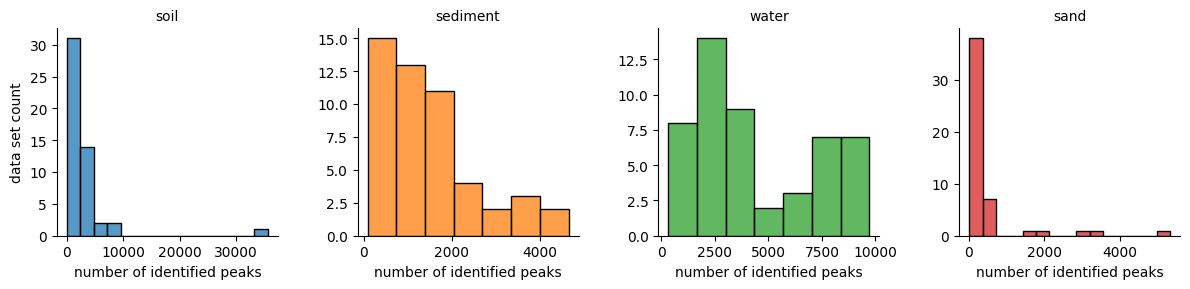

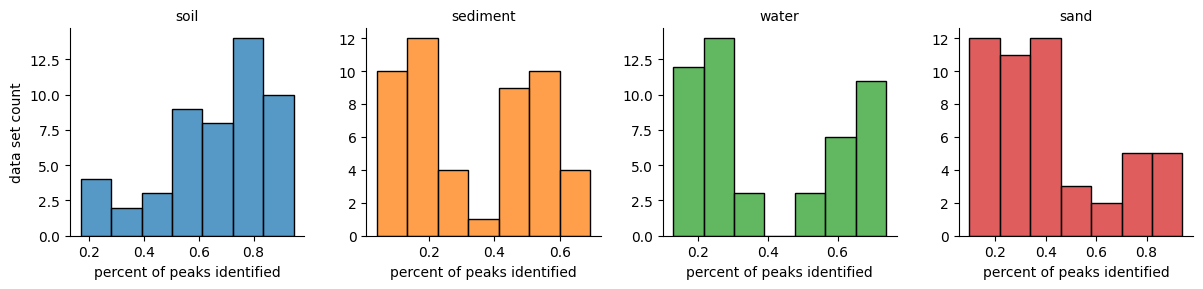

In [20]:
peak_count_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_count_plot.map(sns.histplot,'assigned_peak_count')
peak_count_plot.set_xlabels("number of identified peaks")
peak_count_plot.set_ylabels("data set count")
peak_count_plot.set_titles(col_template="{col_name}")

peak_perc_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_perc_plot.map(sns.histplot,'assigned_perc')
peak_perc_plot.set_xlabels("percent of peaks identified")
peak_perc_plot.set_ylabels("data set count")
peak_perc_plot.set_titles(col_template="{col_name}")

Apply filters to obtain high quality processed NOM data sets without removing all the files from any one sample type. Based on the figures above, requiring files to have at least 250 identified peaks that account for at least 30% of their total peak count will maintain a healthy number of data sets across sample types.

In [21]:
#filter data sets according to stats on peak assignment
nom_filt=nom_summary_df[nom_summary_df['assigned_peak_count']>=250]
nom_filt=nom_filt[nom_filt['assigned_perc']>=0.25]

#expand listed columns in molecular formula df
nom_filt_expanded=nom_filt.explode(['mol_form','H/C','O/C','Confidence Score'])

#resave expanded columns as numeric
nom_filt_expanded['O/C']=pd.to_numeric(nom_filt_expanded['O/C'])
nom_filt_expanded['H/C']=pd.to_numeric(nom_filt_expanded['H/C'])
nom_filt_expanded['Confidence Score']=pd.to_numeric(nom_filt_expanded['Confidence Score'])

#metadata group column
grouping_column='sample_type'

#count number of datasets in each type
count_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates().value_counts(grouping_column)

count_type

sample_type
soil        41
water       29
sediment    26
sand        23
Name: count, dtype: int64

Randomly sample a minimum number of data sets to visualize from each sample type

In [22]:
#determine sampling size based on counts above
n=min(pd.DataFrame(count_type)['count'])

#list the different types
list_type=count_type.index.tolist()

#for each type, randomly sample n data sets and save them into list
nom_sampled=[]
for type in list_type:
    #each processed ID and sample type
    nom_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates()
    #filter to current sample type
    nom_type=nom_type[nom_type[grouping_column]==type]
    #randomly sample n processed IDs in current sample type
    nom_type=nom_type.sample(n=n, random_state=2)
    #save
    nom_sampled.append(nom_type)

#resave list as dataframe
nom_sampled=pd.concat(nom_sampled)

#remerge rest of the data for the sampled data sets
nom_sampled=nom_sampled.merge(nom_filt_expanded,on=['processed',grouping_column],how="left")

nom_sampled

,processed,sample_type,assigned_peak_count,assigned_perc,mol_form,H/C,O/C,Confidence Score
0,nmdc:dobj-11-bp6bnw90,soil,1697,0.259440,C41 H34 O21 S1,0.829268,0.512195,0.513619
1,nmdc:dobj-11-bp6bnw90,soil,1697,0.259440,C60 H92 O3 S1,1.533333,0.050000,0.507658
2,nmdc:dobj-11-bp6bnw90,soil,1697,0.259440,C57 H90 O7,1.578947,0.122807,0.594874
3,nmdc:dobj-11-bp6bnw90,soil,1697,0.259440,C47 H50 O15 S1,1.063830,0.319149,0.599565
4,nmdc:dobj-11-bp6bnw90,soil,1697,0.259440,C41 H42 O22,1.024390,0.536585,0.600000
...,...,...,...,...,...,...,...,...
264516,nmdc:dobj-13-95ygfg27,sand,310,0.873239,C15 H30 O2,2.000000,0.133333,0.597332
264517,nmdc:dobj-13-95ygfg27,sand,310,0.873239,C14 H10 O4,0.714286,0.285714,0.598825
264518,nmdc:dobj-13-95ygfg27,sand,310,0.873239,C15 H28 O2,1.866667,0.133333,0.534896
264519,nmdc:dobj-13-95ygfg27,sand,310,0.873239,C8 H16 O6 S1,2.000000,0.750000,0.078921


Filter to high confidence peaks (score greater than 0.3) and high frequency molecular formulas (present in more than 5 data sets). This will leave us with the most informative data.

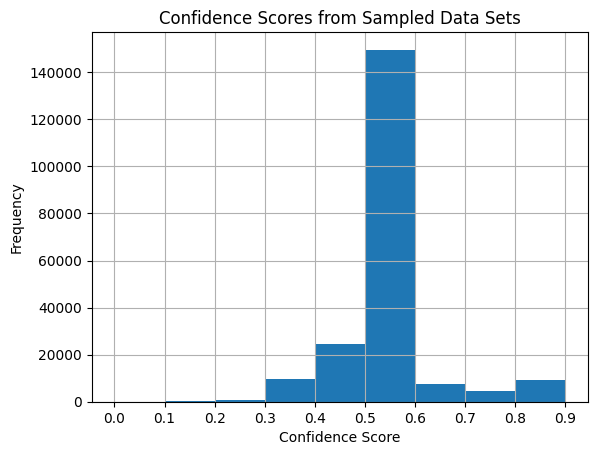

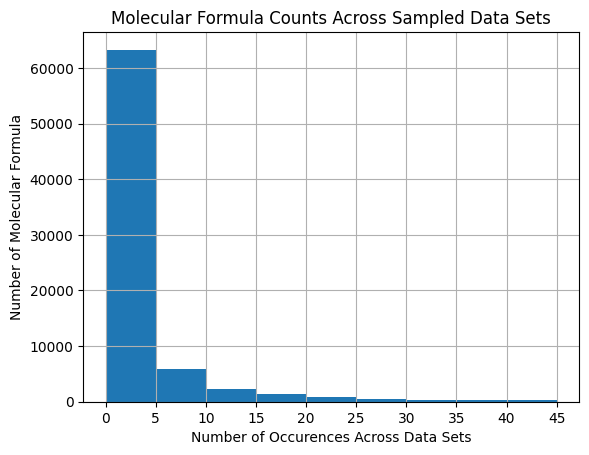

In [23]:
#histogram of confidence scores for randomly selected samples
nom_sampled.hist("Confidence Score",bins=np.arange(0,1,0.1))
plt.title('Confidence Scores from Sampled Data Sets')
plt.xlabel("Confidence Score")
plt.xticks(np.arange(0,1,0.1))
plt.ylabel("Frequency")
plt.show()

#peak filtering by confidence score
conf_filt=nom_sampled[nom_sampled['Confidence Score']>=0.3]

#count for each molecular formula
mol_counts=conf_filt.value_counts('mol_form').to_frame().reset_index()

#histogram of molecular formula counts
mol_counts.hist("count",bins=np.arange(0,50,5))
plt.locator_params(axis='x')
plt.title('Molecular Formula Counts Across Sampled Data Sets')
plt.xlabel("Number of Occurences Across Data Sets")
plt.xticks(np.arange(0,50,5))
plt.ylabel("Number of Molecular Formula")
plt.show()

#based on this histogram, filter to formulas in more than 5 data sets
mol_counts=mol_counts[mol_counts['count']>=5]
mol_filter=mol_counts.merge(conf_filt,on=['mol_form'],how="left")


### Assess patterns in the molecular formulas from different sample types

Create a clustermap of the processed NOM data sets (x axis), indicating the presence (black) or absence (white) of molecular formulas (y axis). The color bar will indicate sample type and help visualize the molecular similarity of data sets both within and between sample types.  

/Users/heal742/LOCAL/05_NMDC/04_notebooks/nmdc_notebooks/nmdc_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/heal742/LOCAL/05_NMDC/04_notebooks/nmdc_notebooks/nmdc_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


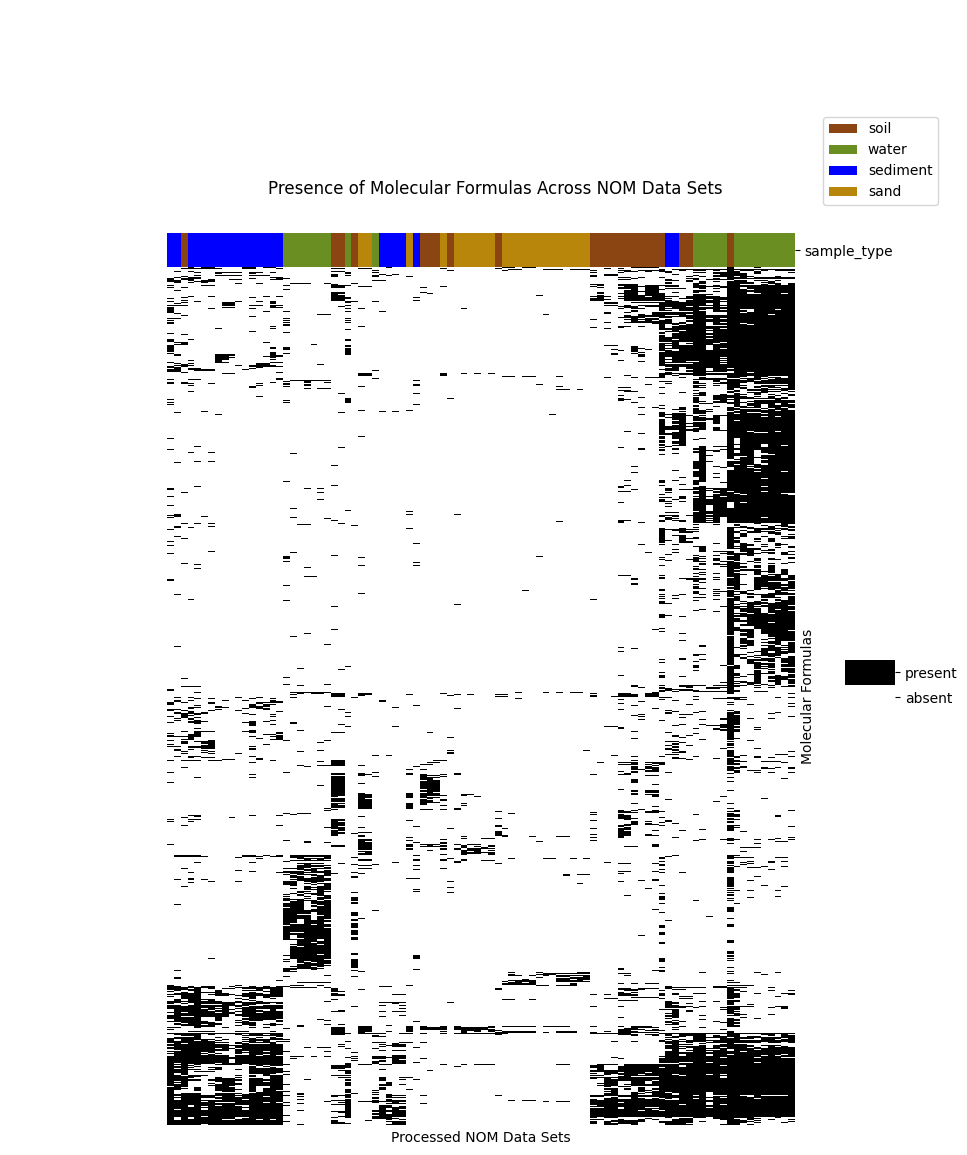

In [24]:
#sample type colors

#set colors for each sample type
type_col=pd.DataFrame({grouping_column:mol_filter[grouping_column].unique(),'color':['#8B4513','olivedrab','blue','#B8860B']})

#setup color legend for sample type
type_col_dict = dict(zip(type_col[grouping_column].unique(), ['#8B4513','olivedrab','blue','#B8860B']))
handles = [Patch(facecolor=type_col_dict[name]) for name in type_col_dict]

#map graph colors based on sample type to processed IDs
sample_type=mol_filter[[grouping_column,'processed']].drop_duplicates()
sample_type_col=sample_type.merge(type_col,how='left',on=grouping_column).set_index('processed').drop(grouping_column,axis=1).rename(columns={'color':grouping_column})

#presence/absence

#set colors for presence/absence as cmap
colors=['white','black']
custom_palette = sns.color_palette(colors)
custom_cmap = sns.color_palette(custom_palette, as_cmap=True)

#add column indicating presence in that processed nom id (1 is present)
mol_filter['presence']=1

#create presence/absence matrix. replace NA with 0 (0 is absent)
formula_matrix=mol_filter[['mol_form','processed','presence']].pivot_table('presence', index='mol_form', columns='processed').fillna(0).astype(int)

#heatmap (1 is present, zero is absent)
g=sns.clustermap(data=formula_matrix,col_colors=sample_type_col,tree_kws={"linewidths": 0.},xticklabels=False,yticklabels=False,cmap=custom_cmap)
g.figure.suptitle("Presence of Molecular Formulas Across NOM Data Sets")
g.ax_heatmap.set_xlabel("Processed NOM Data Sets")
g.ax_heatmap.set_ylabel("Molecular Formulas")

#adjust plot and legend locations
g.figure.subplots_adjust(top=1.15,right=0.8)
g.ax_cbar.set_position((0.85, 0.45, .05, .05)) #x axis,y axis, width, height

#adjust cbar legend to indicate presence/absence
g.ax_cbar.set_yticks([0.25,0.75])
g.ax_cbar.set_yticklabels(["absent","present"])

#add sample type legend
plt.legend(handles, type_col_dict, title=None,
           bbox_to_anchor=(0.95, 1.05), bbox_transform=plt.gcf().transFigure)

Create Van Krevelen diagrams to visually assess the atomic composition of each sample type. Van Krevelen diagrams plot the hydrogen to carbon ratio against the oxygen to carbon ratio, historically to assess petroleum samples.

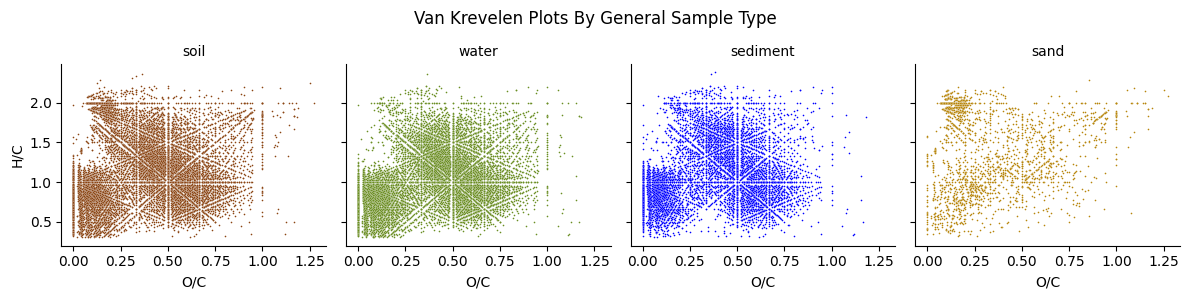

In [27]:
# the same molecular formula will have the same H/C and O/C value in every data set, so dots are only unique per sample type
vankrev_data=mol_filter[[grouping_column,'mol_form','H/C','O/C']].drop_duplicates()

#make van krevlen plot
g=sns.FacetGrid(vankrev_data,col=grouping_column,hue=grouping_column,palette=type_col_dict)
g.map(sns.scatterplot,'O/C','H/C',s=1.5)
g.set_titles(col_template="{col_name}")
g.figure.suptitle("Van Krevelen Plots By General Sample Type")
g.figure.subplots_adjust(top=0.8)

Create marginal density plot to assess how molecular formulas unique to each sample type compare to those shared by all four sample types.

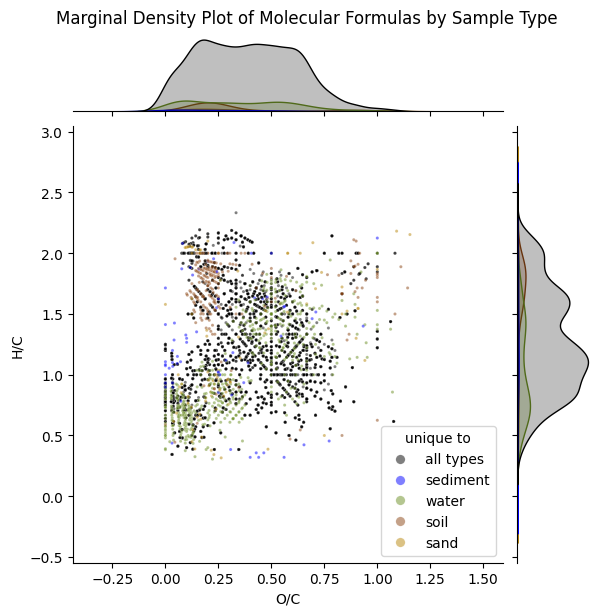

In [30]:
#count the number of sample types in which each molecular formula is found
density_counts=vankrev_data['mol_form'].value_counts()

#map counts back to H/C and O/C data
vankrev_data['common_to'] = vankrev_data['mol_form'].map(density_counts)

#filter molecular formual present in either all four sample types or in only one
vankrev_data=vankrev_data[vankrev_data['common_to'].isin([1,4])]

#reformat so sample type is 'all' when molecular formula was in all
vankrev_data.loc[vankrev_data['common_to']==4,'sample_type']='all types'

#add 'all' to sample type color dictionary
type_col_dict.update({'all types':'black'})

#make marginal density plot
sns.jointplot(data=vankrev_data, x="O/C", y="H/C", kind="scatter", hue=grouping_column,palette=type_col_dict,s=5,alpha=0.5)
plt.legend(markerscale=3,title="unique to")
plt.suptitle("Marginal Density Plot of Molecular Formulas by Sample Type",y=1.02)
plt.show()
